<a href="https://colab.research.google.com/github/CCMunozB/Patrones/blob/main/9-domain_specific_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recurrent Neural Networks

Preparamos el ambiente de trabajo de Google Colab

In [1]:
!wget https://zenodo.org/record/3924799/files/cwlce.vec # Descargamos los embedding clínicos calculados por PLN@CMM

--2023-06-06 19:21:48--  https://zenodo.org/record/3924799/files/cwlce.vec
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 163303193 (156M) [application/octet-stream]
Saving to: ‘cwlce.vec’

cwlce.vec           100%[===================>] 155.74M  4.61MB/s    in 84s     

2023-06-06 19:23:14 (1.85 MB/s) - ‘cwlce.vec’ saved [163303193/163303193]



In [2]:
!wget https://users.dcc.uchile.cl/~fvillena/files/cwlce_vocab.txt # Descargamos el vocabulario del texto

--2023-06-06 19:23:15--  https://users.dcc.uchile.cl/~fvillena/files/cwlce_vocab.txt
Resolving users.dcc.uchile.cl (users.dcc.uchile.cl)... 192.80.24.4, 200.9.99.211
Connecting to users.dcc.uchile.cl (users.dcc.uchile.cl)|192.80.24.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 574476 (561K) [text/plain]
Saving to: ‘cwlce_vocab.txt’

cwlce_vocab.txt     100%[===================>] 561.01K   411KB/s    in 1.4s    

2023-06-06 19:23:18 (411 KB/s) - ‘cwlce_vocab.txt’ saved [574476/574476]



In [3]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 56.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 18.2 MB/s eta 0:00:00


In [4]:
import tensorflow as tf # Biblioteca de deep learning
import gensim # Biblioteca de modelamiento de lenguaje
import datasets # Biblioteca de manejo de conjuntos de datos para procesamiento de lenguaje natural
import numpy as np # Biblioteca de manejo de datos vectoriales
import matplotlib.pyplot as plt # Biblioteca de visualización

Cargamos el conjunto de datos del curso.

In [5]:
spanish_diagnostics = datasets.load_dataset('fvillena/spanish_diagnostics') # Cargamos las particiones de entrenamiento y prueba

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset spanish_diagnostics downloaded and prepared to /root/.cache/huggingface/datasets/fvillena___spanish_diagnostics/default/0.0.0/45c176cea64580ea9631f78c2867a657ede368597681e5337e9f1c976e4e84ff. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

## Preprocesamiento

In [6]:
import re
def normalize(text, remove_tildes = True):
    """Normaliza una cadena de texto convirtiéndo todo a minúsculas, quitando los caracteres no alfabéticos y los tildes"""
    text = text.lower() # Llevamos todo a minúscula
    text = re.sub(r'[^A-Za-zñáéíóú]', ' ', text) # Reemplazamos los caracteres no alfabéticos por un espacio
    if remove_tildes:
        text = re.sub('á', 'a', text) # Reemplazamos los tildes
        text = re.sub('é', 'e', text)
        text = re.sub('í', 'i', text)
        text = re.sub('ó', 'o', text)
        text = re.sub('ú', 'u', text)
    return text

Normalizamos el corpus.

In [7]:
spanish_diagnostics_normalized = spanish_diagnostics.map(
    lambda x: { 
        "normalized_text" : normalize(x["text"]) 
    })

Map:   0%|          | 0/70000 [00:00<?, ? examples/s]

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Para poder pasar nuestros documentos por la red neuronal, cada uno debe ser convertido a una secuencia de índices de palabras del vocabulario. Además, debemos asegurarnos que cada una de las secuencias que utilizaremos para entrenar el modelo tiene el mismo largo.

Primero tokenizamos el texto crudo.

In [8]:
document = spanish_diagnostics_normalized["train"]["normalized_text"][0]
document

'  anomalias dentofaciales  incluso la maloclusion     discrepancia dentomaxilar'

In [9]:
tokens = tf.keras.preprocessing.text.text_to_word_sequence(document)
tokens

['anomalias',
 'dentofaciales',
 'incluso',
 'la',
 'maloclusion',
 'discrepancia',
 'dentomaxilar']

Convertimos esta lista de tokens en una lista de índices de palabras respecto al vocabulario, sólo si esta palabra está en el vocabulario.

In [10]:
vocab = []
with open("cwlce_vocab.txt", 'r', encoding="utf-8") as f:
  for line in f:
    vocab.append(line.strip())
sequence = [vocab.index(word) for word in tokens if word in vocab]
sequence

[76, 123, 131, 3, 83, 2552, 737]

Finalmente agregamos ceros al principio de nuestra secuencia para que todas tengan exactamente el mismo largo.

In [11]:
padded_sequence = tf.keras.preprocessing.sequence.pad_sequences([sequence], maxlen=20)
padded_sequence

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,   76,  123,  131,    3,   83, 2552,  737]],
      dtype=int32)

Consolidamos todo en una función.

In [12]:
def text_to_sequence(text,vocab):
  """Esta función recibe una lista de strings y devuelve una lista de listas de índices del vocabulario"""
  sequences = []
  tokens = tf.keras.preprocessing.text.text_to_word_sequence(text)
  sequence = [vocab.index(word) for word in tokens if word in vocab]
  sequences.append(sequence)
  return sequences

In [13]:
def encode_text(text,vocab,maxlen=20):
  """Esta función recibe string y devuelve una lista de índices del vocabulario con padding"""
  sequences = text_to_sequence(text,vocab)
  padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=maxlen)
  return padded_sequences[0]

Verificamos cómo funciona nuestra función.

In [14]:
encode_text("cancer    de colon",vocab)

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0, 192,   1, 235], dtype=int32)

Aplicamos nuestra función a todo el corpus.

In [15]:
spanish_diagnostics_normalized_encoded = spanish_diagnostics_normalized.map(
    lambda x: { 
        "encoded_text" : encode_text(x["normalized_text"],vocab) 
    })

Map:   0%|          | 0/70000 [00:00<?, ? examples/s]

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Así se ve una instancia de nuestro dataset.

In [16]:
spanish_diagnostics_normalized_encoded["train"][0]

{'text': '- ANOMALÍAS DENTOFACIALES (INCLUSO LA MALOCLUSIÓN)\n\n\n DISCREPANCIA DENTOMAXILAR',
 'label': 1,
 'normalized_text': '  anomalias dentofaciales  incluso la maloclusion     discrepancia dentomaxilar',
 'encoded_text': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  76,
  123,
  131,
  3,
  83,
  2552,
  737]}

## Modelamiento

El primer paso del modelamiento es declarar la arquitectura que tendrá nuestra red neuronal. El tipo de red neuronal más utilizado para resolver tareas relacionadas con textos son las redes neuronales recurrentes. 

En este caso diseñaremos una red neuronal recurrente simple en donde cada una de las celdas de la red neuronal toma como entrada la salida del paso anterior en la secuencia.

La primera capa de nuestra arquitectura será la representación de cada una de las palabras del corpus a través de un embedding. Esta capa representará la secuencia de índices como una secuencia de embeddings asociados a cada palabra del vocabulario.

Esta secuencia de embeddings se pasará de manera serial por la capa recurrente simple y el estado oculto asociado al último paso de la secuencia será la representación asociada a la secuencia completa.

Esta representación de la secuencia entrará a la última capa densa que contiene sólo una neurona que representará la salida verdadera o falsa de nuestra red.

Especificamente en esta instancia compararemos los rendimientos de esta arquitectura al inicializar la capa de embedding con valores al azar y al inicializar la capa de embedding con valores preentrenados. También cada modelo tendrá una versión en donde sí estamos ajustando los embedding y donde no estamos ajustando los embedding.

In [17]:
def make_model(embedding,trainable_embeddings,vocab):
  """Con esta función instanciamos la arquitectura de red neuronal recurrente."""
  model = tf.keras.Sequential() # La declaración de la arquitectura se hará de manera secuencial. La salida de la capa será la entrada de la capa siguiente.
  if embedding == "random": # La capa de embedding estará condicionada con esto.
    embedding_layer = tf.keras.layers.Embedding( # Esta capa de embedding se inicializará con valores al azar.
        input_dim=len(vocab), # La cantidad de embeddings (filas) será igual al tamaño del vocabulario.
        output_dim=300, # Cada palabra se representará con 300 dimensiones-
        trainable=trainable_embeddings, # Con esto declaramos si se ajustará o no la capa de embedding.
        mask_zero=True # Con esto omitimos pasar a la siguiente capa la representación del padding.
    )
  else:
    embedding_layer = tf.keras.layers.Embedding(
        input_dim=len(vocab), 
        output_dim=embedding.vectors.shape[1], 
        trainable=trainable_embeddings, 
        weights=[embedding.vectors], # Inicializamos la capa de embedding con los embedding preentrenados.
        mask_zero=True
    )
  model.add(embedding_layer) # Agregamos la capa de embedding a la arquitectura
  model.add(tf.keras.layers.SimpleRNN( # Agregamos la capa recurrente a la arquitectura
      128, # La salida de esta capa tendrá 128 dimensiones
      recurrent_dropout=0.2)) # Al azar cambia por 0 el 30 % de los pesos con el fin de disminuir el sobreajuste.
  model.add(tf.keras.layers.Dropout(0.3)) # Esta capa al azar cambia por 0 el 30 % de los pesos con el fin de disminuir el sobreajuste.
  model.add(tf.keras.layers.Dense(1, activation='sigmoid')) # Esta es la capa de clasificación binaria.
  model.compile( # Compilamos el modelo
      loss='binary_crossentropy', # Utilizamos entropia cruzada binaria debido a la que la capa de clasificación es binaria
      optimizer='adam', # Usamos ADAM como optimización, un descenso de gradientes "inteligente".
      metrics=['accuracy']) # Medimos el rendimiento de la clasificación con accuracy debido a que nuestras clases están balanceadas.
  return model

In [18]:
spanish_diagnostics_normalized_encoded.set_format(type="numpy", columns=["encoded_text","label"]) # transformamos las características a arreglos de numpy

### Entrenamiento

Entrenaremos 2 modelos distintos y compararemos sus resultados:

1.   Modelo sin utilizar embeddings preentrenados, sólo ajustándolos en el entrenamiento.
2.   Modelo sin utilizar embeddings preentrenados y sin ajustarlos en el entrenamiento.


#### Los embeddings se ajustan en el entrenamiento

No utilizaremos los embeddings preentrenados, los ajustaremos mientras se resuelve la tarea de clasificación

In [19]:
model_random_trainable = make_model(
    embedding = "random", # No usamos embeddings preentrenados.
    trainable_embeddings = True,
    vocab = vocab
)
model_random_trainable_hist = model_random_trainable.fit(
    spanish_diagnostics_normalized_encoded["train"]["encoded_text"][:7000],
    spanish_diagnostics_normalized_encoded["train"]["label"][:7000],
    epochs=10,
    validation_data=(
        spanish_diagnostics_normalized_encoded["test"]["encoded_text"][:3000],
        spanish_diagnostics_normalized_encoded["test"]["label"][:3000],
    )
)

Epoch 1/10
219/219 [==============================] - 35s 122ms/step - loss: 0.3246 - accuracy: 0.8784 - val_loss: 0.1814 - val_accuracy: 0.9463
Epoch 2/10
219/219 [==============================] - 14s 63ms/step - loss: 0.1212 - accuracy: 0.9649 - val_loss: 0.1700 - val_accuracy: 0.9420
Epoch 3/10
219/219 [==============================] - 12s 53ms/step - loss: 0.0774 - accuracy: 0.9783 - val_loss: 0.1903 - val_accuracy: 0.9330
Epoch 4/10
219/219 [==============================] - 11s 52ms/step - loss: 0.0508 - accuracy: 0.9843 - val_loss: 0.2584 - val_accuracy: 0.9323
Epoch 5/10
219/219 [==============================] - 11s 51ms/step - loss: 0.0383 - accuracy: 0.9874 - val_loss: 0.2650 - val_accuracy: 0.9327
Epoch 6/10
219/219 [==============================] - 11s 49ms/step - loss: 0.0362 - accuracy: 0.9893 - val_loss: 0.3240 - val_accuracy: 0.9290
Epoch 7/10
219/219 [==============================] - 10s 46ms/step - loss: 0.0281 - accuracy: 0.9920 - val_loss: 0.2804 - val_accuracy

#### Los embeddings no se ajustan en el entrenamiento ni se preentrenan

No utilizaremos los embeddings preentrenados ni los ajustaremos mientras se resuelve la tarea de clasificación

In [20]:
model_random_frozen = make_model(
    embedding = "random",
    trainable_embeddings = False,
    vocab = vocab
)
model_random_frozen_hist = model_random_frozen.fit(
    spanish_diagnostics_normalized_encoded["train"]["encoded_text"][:7000],
    spanish_diagnostics_normalized_encoded["train"]["label"][:7000],
    epochs=10,
    validation_data=(
        spanish_diagnostics_normalized_encoded["test"]["encoded_text"][:3000],
        spanish_diagnostics_normalized_encoded["test"]["label"][:3000],
    )
)

Epoch 1/10
219/219 [==============================] - 10s 38ms/step - loss: 0.5679 - accuracy: 0.7489 - val_loss: 0.4465 - val_accuracy: 0.8367
Epoch 2/10
219/219 [==============================] - 10s 44ms/step - loss: 0.4386 - accuracy: 0.8311 - val_loss: 0.4535 - val_accuracy: 0.8493
Epoch 3/10
219/219 [==============================] - 9s 43ms/step - loss: 0.3972 - accuracy: 0.8446 - val_loss: 0.3920 - val_accuracy: 0.8543
Epoch 4/10
219/219 [==============================] - 9s 40ms/step - loss: 0.3763 - accuracy: 0.8500 - val_loss: 0.3494 - val_accuracy: 0.8573
Epoch 5/10
219/219 [==============================] - 9s 41ms/step - loss: 0.3720 - accuracy: 0.8567 - val_loss: 0.3448 - val_accuracy: 0.8613
Epoch 6/10
219/219 [==============================] - 10s 48ms/step - loss: 0.3626 - accuracy: 0.8566 - val_loss: 0.3455 - val_accuracy: 0.8583
Epoch 7/10
219/219 [==============================] - 10s 46ms/step - loss: 0.3577 - accuracy: 0.8627 - val_loss: 0.3584 - val_accuracy: 0.

### Comparación

Compararemos cómo se van comportando las métricas objetivo a medida que avanzaron las épocas.

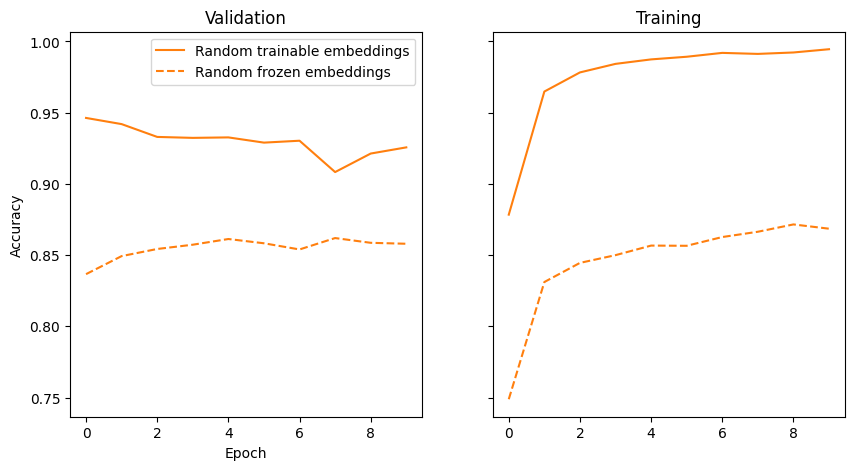

In [21]:
fig, axs = plt.subplots(1,2,figsize=(10,5),sharex=True,sharey=True)

axs[0].plot(
    model_random_trainable_hist.history["val_accuracy"],
    c="tab:orange",
    label="Random trainable embeddings"
)
axs[0].plot(
    model_random_frozen_hist.history["val_accuracy"],
    c="tab:orange",
    linestyle="--",
    label="Random frozen embeddings"
)

axs[1].plot(
    model_random_trainable_hist.history["accuracy"],
    c="tab:orange",
    label="Random trainable embeddings"
)
axs[1].plot(
    model_random_frozen_hist.history["accuracy"],
    c="tab:orange",
    linestyle="--",
    label="Random frozen embeddings"
)
axs[0].legend()
axs[0].set_title("Validation")
axs[1].set_title("Training")
axs[0].set_ylabel("Accuracy")
axs[0].set_xlabel("Epoch")
plt.show()

### Actividad

Entrene modelos utilizando embeddings preentrenados clínicos congelando o no la capa de embeddings y comparelos con los resultados de los modelos que no usaton modelos preentrenados.

HINT: El vocabulario de `cwlce.vec` es el mismo del objeto `vocab`

In [22]:
# cwlce = gensim.models.KeyedVectors.load_word2vec_format("cwlce.vec")